In [1]:
import numpy as np
from numpy.core.fromnumeric import shape
import os

In [2]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/home/max/projects/masterthesis/mini_nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.606 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
# Load last 3 point clouds
#############################3
# Print List of scenes
nusc.list_scenes()

#Get set of scenes
scenes = nusc.scene
#Get first scenes
scene_0 = scenes[0]
# Get token of first frame
first_sample_token = scene_0['first_sample_token']
sample_0 = nusc.get('sample', first_sample_token)
# Get tokens for 2 following frames
second_sample_token = sample_0['next']
sample_1 = nusc.get('sample', second_sample_token)
third_sample_token = sample_1['next']
sample_2 = nusc.get('sample', third_sample_token)

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [4]:
sample_1

{'token': '39586f9d59004284a7114a68825e8eec',
 'timestamp': 1532402928147847,
 'prev': 'ca9a282c9e77460f8360f564131a8af5',
 'next': '356d81f38dd9473ba590f39e266f54e5',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': 'b70cefb08263499eb30c7e7da0031428',
  'RADAR_FRONT_LEFT': 'b5cd02b25f0944f19c0d123fa1fc54ec',
  'RADAR_FRONT_RIGHT': '9b628ce4952a4a839962b77a76630e23',
  'RADAR_BACK_LEFT': '28b610ada2b545d1a5a1bf9d08af0285',
  'RADAR_BACK_RIGHT': '07a62118eb3b43ffa1d833f250ff6f80',
  'LIDAR_TOP': '4f792c8da81e4cb7aca1790654da1c27',
  'CAM_FRONT': '4b6870ae200c4b969b91c50a9737f712',
  'CAM_FRONT_RIGHT': '5c026763ad8146e89c6ee53da26331dc',
  'CAM_BACK_RIGHT': 'c339f7629fdf4c219e30ca1790b53773',
  'CAM_BACK': '661d9842bbb44b208f867f2061c4f535',
  'CAM_BACK_LEFT': '9320f00a62c24b80972048de7a742b4c',
  'CAM_FRONT_LEFT': '2b9d52c5c777455eb31831860c6fc117'},
 'anns': ['7987617983634b119e383d8a29607fd7',
  '216bbbd8e01c450a8fabe9d47433c10a',
  'f0cbd9dbafd74e20bcf6dd0

In [5]:
# Get LIDAR pointcloud
sensor = 'LIDAR_TOP'
lidar_top_data_0 = nusc.get('sample_data', sample_0['data'][sensor])
lidar_top_data_0

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402927647951,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin',
 'prev': '',
 'next': '0cedf1d2d652468d92d23491136b5d15',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [6]:
# Get LIDAR KF pointcloud
lidar_top_data_1 = nusc.get('sample_data', sample_1['data'][sensor])
assert lidar_top_data_1['is_key_frame'] == True
print(lidar_top_data_1)

# Get LIDAR KF pointcloud
lidar_top_data_2 = nusc.get('sample_data', sample_2['data'][sensor])
assert lidar_top_data_2['is_key_frame'] == True
lidar_top_data_2

{'token': '4f792c8da81e4cb7aca1790654da1c27', 'sample_token': '39586f9d59004284a7114a68825e8eec', 'ego_pose_token': '4f792c8da81e4cb7aca1790654da1c27', 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c', 'timestamp': 1532402928147847, 'fileformat': 'pcd', 'is_key_frame': True, 'height': 0, 'width': 0, 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928147847.pcd.bin', 'prev': '6c68f70d05d74994817f11131fb21f3d', 'next': '38f3e46f0845441295e639bc5a4e24ca', 'sensor_modality': 'lidar', 'channel': 'LIDAR_TOP'}


{'token': '28aaabeb212146a28a511858c09cf20c',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '28aaabeb212146a28a511858c09cf20c',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402928698048,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928698048.pcd.bin',
 'prev': '46aae6c1703e4bd08b4e1d2918eaf724',
 'next': 'b0a057549fb24e938f94f717c4f7446a',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [7]:
# nusc.render_sample_data(lidar_top_data_0['token'])
# nusc.render_sample_data(lidar_top_data_1['token'])
# nusc.render_sample_data(lidar_top_data_2['token'])

In [8]:
# Get point clouds
import os.path as osp
from nuscenes.utils.data_classes import LidarPointCloud, Box

pcl0_path = osp.join(nusc.dataroot, lidar_top_data_0['filename'])
pcl1_path = osp.join(nusc.dataroot, lidar_top_data_1['filename'])
pcl2_path = osp.join(nusc.dataroot, lidar_top_data_2['filename'])
#Load Pointclouds
pc0 = LidarPointCloud.from_file(pcl0_path)
pc1 = LidarPointCloud.from_file(pcl1_path)
pc2 = LidarPointCloud.from_file(pcl2_path)

In [9]:
# Get set of object centers

_, boxes0, _= nusc.get_sample_data(lidar_top_data_0['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)
_, boxes1, _= nusc.get_sample_data(lidar_top_data_1['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)
_, boxes2, _= nusc.get_sample_data(lidar_top_data_2['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)
# for box in boxes:
    # c = np.array(self.get_color(box.name)) / 255.0
    # box.render(axes[0], view=view, colors=(c, c, c))
    # corners = view_points(boxes[0].corners(), view, False)[:2, :]

In [10]:
# Load point clouds
pc0.points

print("rows:",np.size(pc0.points,0))
print("columns:",np.size(pc0.points,1))


rows: 4
columns: 34688


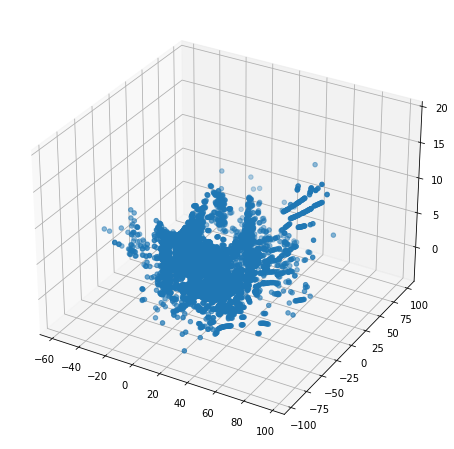

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
# Plot 3D pointcloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pc0.points[0], pc0.points[1], pc0.points[2])
plt.show()


In [12]:
# test out Boxes
print(boxes0[0])
print(type(boxes0[0].center))
print(type(boxes0[0].wlh))
print(type(boxes0[0].orientation.angle))


label: nan, score: nan, xyz: [18.41, 59.52, 0.77], wlh: [0.62, 0.67, 1.64], rot axis: [0.01, -0.02, 1.00], ang(degrees): 179.02, ang(rad): 3.12, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'float'>


In [13]:
from open3d_vis import Visualizer
# # visualization
pc0_transposed = np.transpose(pc0.points)
print("Shape:",np.shape(pc0_transposed))


boxes_kitti_style = []
for box in boxes0:
    boxes_kitti_style.append(box.center.tolist() + box.wlh.tolist() + [box.orientation.angle])

boxes_kitti_style = np.asarray(boxes_kitti_style)
print(boxes_kitti_style[0:1])
print(type(boxes_kitti_style[0:1]))
print("Shape:",np.shape(boxes_kitti_style))

print(boxes_kitti_style[0:1,0:3])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Shape: (34688, 4)
[[18.414385   59.51602513  0.76963457  0.621       0.669       1.642
   3.12440813]]
<class 'numpy.ndarray'>
Shape: (69, 7)
[[18.414385   59.51602513  0.76963457]]


In [14]:

# #Add Pointcloud to visualizer
# results = Visualizer(pc0_transposed, center_mode='lidar_bottom',points_size=3)
# #Add Bounding Boxes
# results.add_bboxes(boxes_kitti_style, bbox_color=[0.9, 0.2, 0])
# results.show(save_path=None)


In [15]:
# Get set of object centers
# Stack Boxes/Centroids
from utility import get_box_centers

centers0 = get_box_centers(boxes0)
centers1 = get_box_centers(boxes1)
centers2 = get_box_centers(boxes2)

# Testing numpy commands
# print(centers0[0:3, 0:2])
# print(centers0.shape[1])
# print(np.ones((centers0.shape[1],centers0.shape[1])))
# centers0 @ np.ones((centers0.shape[1],centers0.shape[1]))

# Special Shift parameter in meter
l = 20
# Boxes 0 can stay at the current frame
# centers0
# Boxes 1 must be translated up by l meters
print(centers1[0])
centers1 += np.array([0,0,l])
print(centers1[0])
# Boxes 2 must be translated up by 2*l meters
centers2 += np.array([0,0,2*l])

# Add all centroids into one array
centers = np.empty((0,3))
centers = np.append(centers, centers0, axis=0)
centers = np.append(centers, centers1, axis=0)
centers = np.append(centers, centers2, axis=0)

assert centers.shape[0] == centers0.shape[0] \
            + centers1.shape[0] + centers2.shape[0]

print(centers[0:4])

[18.72765914 54.91021561  0.73102789]
[18.72765914 54.91021561 20.73102789]
[[ 1.84143850e+01  5.95160251e+01  7.69634574e-01]
 [ 2.10021070e+01  3.60611085e+01 -2.61477977e-02]
 [ 3.73518608e+01  6.43973387e+01  4.50991675e-01]
 [ 2.53650507e+01  3.21656131e+01 -1.56578802e-01]]


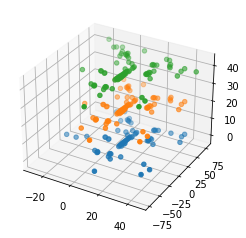

In [16]:
fig_centers = plt.figure()
ax = fig_centers.add_subplot(111,projection='3d')

# ax.scatter(centers[:,0], centers[:,1], centers[:,2])
ax.scatter(centers0[:,0], centers0[:,1], centers0[:,2])
ax.scatter(centers1[:,0], centers1[:,1], centers1[:,2])
ax.scatter(centers2[:,0], centers2[:,1], centers2[:,2])

In [17]:
#Add Pointcloud to visualizer
# results = Visualizer(centers, center_mode='lidar_bottom',points_size=3)
# results.show(save_path=None)


In [18]:
# Build KNN Graph
from sklearn.neighbors import NearestNeighbors
# Init NN-object to handle distance meassurements and other operations
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centers)
# Compute Distances and indices of k center-entries that lie the nearest to current centroids
distances, indices = nbrs.kneighbors(centers)
print("Indices:\n",indices[0:3],"Shape: ",indices.shape)
print("Distances:\n",distances[0],"Shape: ",distances.shape)

# Show connectivity of graph
print(nbrs.kneighbors_graph(centers).toarray())


Indices:
 [[ 0  5 17 54 40]
 [ 1 31 50  6  3]
 [ 2 45 40 13 54]] Shape:  (233, 5)
Distances:
 [ 0.          1.31925433  1.95167159  3.80276978 12.39774536] Shape:  (233, 5)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [44]:
#Build graph in a more organised manner
from graph.graph_generation import SpatioTemporalGraph, Timeframe

nbrs_0 = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centers0)

# Add spatial edges #####################

# TODO NearestNeighbors includes the current node. 
#       Change it so that nodes do not point at themselves

# Frame t0
#Compute K nearest neighbors
spatial_distances_0, spatial_indices_0=nbrs_0.kneighbors(centers0)
# Make a list of tuple pairs
spatial_pairs = [] 
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_0):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t0,curr_node_idx) , ((Timeframe.t0,neigbor_index)) ) )

#Frame t1
nbrs_1 = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centers1)
spatial_distances_1, spatial_indices_1=nbrs_1.kneighbors(centers1)
# Make a list of tuple pairs
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_1):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t1,curr_node_idx) , ((Timeframe.t1,neigbor_index)) ) )

#Frame t2
nbrs_2 = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centers2)
spatial_distances_2, spatial_indices_2=nbrs_2.kneighbors(centers2)
# Make a list of tuple pairs
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_2):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t2,curr_node_idx) , ((Timeframe.t2,neigbor_index)) ) )

testgraph = SpatioTemporalGraph(spatial_pairs)


In [45]:
from utility import is_same_instance

print(nusc.get('sample_annotation', boxes0[0].token))

print("Same Instances: ",is_same_instance(nusc, boxes0[0].token,boxes0[0].token))
print("Different Instances:",is_same_instance(nusc, boxes0[0].token,boxes0[1].token))

{'token': 'ef63a697930c4b20a6b9791f423351da', 'sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5', 'visibility_token': '1', 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'], 'translation': [373.256, 1130.419, 0.8], 'size': [0.621, 0.669, 1.642], 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616], 'prev': '', 'next': '7987617983634b119e383d8a29607fd7', 'num_lidar_pts': 1, 'num_radar_pts': 0, 'category_name': 'human.pedestrian.adult'}
Same Instances:  True
Different Instances: False


In [46]:
# Add temporal edges #####################
# Only connect unique objects to themselves. Only Connect boxes
# that belong to the same object instance and subsequently same class
#Initiate graph
temporal_pairs = []
# Looking for connections between frame i and frame j
# Frame 0 ==> Frame 1
for i,box_i in enumerate(boxes0):
    for j,box_j in enumerate(boxes1):
        if is_same_instance(nusc, box_i.token, box_j.token):
            temporal_pairs.append( \
                ( (Timeframe.t0,i) , ((Timeframe.t1,j)) ) )
print(np.shape(temporal_pairs))
# Frame 1 ==> Frame 2
for i,box_i in enumerate(boxes1):
    for j,box_j in enumerate(boxes2):
        if is_same_instance(nusc, box_i.token, box_j.token):
            temporal_pairs.append( \
                ( (Timeframe.t1,i) , ((Timeframe.t2,j)) ) )
print(np.shape(temporal_pairs))
print(temporal_pairs[0])

testgraph.add_connections(temporal_pairs)


(67, 2, 2)
(144, 2, 2)
((<Timeframe.t0: 0>, 0), (<Timeframe.t1: 1>, 0))


In [47]:
print("Time 0:\n",testgraph._graph[(Timeframe.t0,0)])
print("Time 1:\n",testgraph._graph[(Timeframe.t1,0)])
print("Time 2:\n",testgraph._graph[(Timeframe.t2,0)])
# print("Whole Graph\n",testgraph._graph)

Time 0:
 {(<Timeframe.t0: 0>, 0), (<Timeframe.t0: 0>, 17), (<Timeframe.t0: 0>, 54), (<Timeframe.t0: 0>, 5), (<Timeframe.t1: 1>, 0), (<Timeframe.t0: 0>, 40)}
Time 1:
 {(<Timeframe.t1: 1>, 57), (<Timeframe.t1: 1>, 18), (<Timeframe.t1: 1>, 41), (<Timeframe.t0: 0>, 0), (<Timeframe.t1: 1>, 5), (<Timeframe.t2: 2>, 0), (<Timeframe.t1: 1>, 0)}
Time 2:
 {(<Timeframe.t2: 2>, 63), (<Timeframe.t2: 2>, 47), (<Timeframe.t2: 2>, 5), (<Timeframe.t2: 2>, 20), (<Timeframe.t2: 2>, 0), (<Timeframe.t1: 1>, 0)}


In [48]:
# # Draw 3D Graph

# results = Visualizer(centers, center_mode='lidar_bottom',points_size=3)

# results.show(save_path=None)

In [49]:
# Get all spatial Edges
spatial_pointpairs0 = []
for reference_node in testgraph._graph:
    if(reference_node[0]== Timeframe.t0):
        for neighbor_node in testgraph._graph[reference_node]:
            # print(neighbor_index[0])
            timestep, idx = neighbor_node[0],neighbor_node[1]
            if timestep == Timeframe.t0:
                spatial_pointpairs0.append([reference_node[1],idx])

print(np.shape(spatial_pointpairs0))
testarray = testgraph.get_spatial_pointpairs(Timeframe.t0)
assert spatial_pointpairs0 == testarray

spatial_pointpairs1 = testgraph.get_spatial_pointpairs(Timeframe.t1)
spatial_pointpairs2 = testgraph.get_spatial_pointpairs(Timeframe.t2)

(413, 2)


In [50]:
np.argwhere(centers == centers0[-1])
np.argwhere(centers == centers1[-1])[0,0]

146

In [51]:
# Get all temporal edges

# Get points 
def get_points(centers0, centers1 ,centers2,reference_node):
    if(reference_node[0]== Timeframe.t0):
        return centers0[reference_node[1]]
    elif (reference_node[0]== Timeframe.t1):
        return centers1[reference_node[1]]
    elif (reference_node[0]== Timeframe.t2):
        return centers2[reference_node[1]]
    else:
        return AttributeError
        
# Get all temporal edges (only frame 0->1 and 1->2)
# global_center_list = centers.tolist()
temporal_pairs_indices = []
for reference_node in testgraph._graph:
    reference_timeframe = reference_node[0]

    # Find corresponding indices in global centers list
    point_a = get_points(centers0, centers1 ,centers2,reference_node)
    reference_idx_global = np.argwhere(centers == point_a)[0,0]

    for neighbor_node in testgraph._graph[reference_node]:
        # print(neighbor_index[0])
        neighbor_timeframe, neighbor_idx = neighbor_node[0],neighbor_node[1]
        if neighbor_timeframe != reference_timeframe:
            # Find corresponding indices in global centers list
            # Reference Node
            point_b = get_points(centers0, centers1 ,centers2,neighbor_node)
            neighbor_idx_global = np.argwhere(centers == point_b)[0,0]
            #Append global indices into list
            temporal_pairs_indices.append([reference_idx_global,neighbor_idx_global])


In [52]:
import open3d as o3d
from open3d import geometry

############ Parameters
upward_shift = 20
##############

# Integrate All Center points in Pointcloud-object not necessary but test
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(centers)

# Include Pointcloud of timeframe 0 into visualization 
pc0_transposed = np.transpose(pc0.points)
print("Shape:",np.shape(pc0_transposed))
pointcloud0 = o3d.geometry.PointCloud()
pointcloud0.points = o3d.utility.Vector3dVector(pc0_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc0_transposed.shape[0], 1))
pointcloud0.colors = o3d.utility.Vector3dVector(points_colors)

# Include Pointcloud of timeframe 1 into visualization 
pc1_transposed = np.transpose(pc1.points)
print("Shape:",np.shape(pc1_transposed))
pointcloud1 = o3d.geometry.PointCloud()
pointcloud1.points = o3d.utility.Vector3dVector(pc1_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc1_transposed.shape[0], 1))
pointcloud1.colors = o3d.utility.Vector3dVector(points_colors)
# Translate up to stack the point clouds
pointcloud1.translate(np.array([0,0,upward_shift]))

# Include Pointcloud of timeframe 2 into visualization 
pc2_transposed = np.transpose(pc2.points)
print("Shape:",np.shape(pc2_transposed))
pointcloud2 = o3d.geometry.PointCloud()
pointcloud2.points = o3d.utility.Vector3dVector(pc2_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc2_transposed.shape[0], 1))
pointcloud2.colors = o3d.utility.Vector3dVector(points_colors)
# Translate up to stack the point clouds
pointcloud2.translate(np.array([0,0,upward_shift * 2]))

# Include reference frame
mesh_frame = geometry.TriangleMesh.create_coordinate_frame(
            size=1, origin=[0, 0, 0])  # create coordinate frame

# Draw Graph/Edges with Lineset
# Spatial Edges Red Edges
colors = [[1, 0, 0] for i in range(len(spatial_pointpairs0))]
line_set0 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers0),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs0),)
line_set0.colors = o3d.utility.Vector3dVector(colors)

colors = [[1, 0, 0] for i in range(len(spatial_pointpairs1))]
line_set1 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers1),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs1),)
line_set1.colors = o3d.utility.Vector3dVector(colors)

colors = [[1, 0, 0] for i in range(len(spatial_pointpairs2))]
line_set2 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers2),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs2),)
line_set2.colors = o3d.utility.Vector3dVector(colors)

# Temporal Edges 
colors = [[0, 0, 1] for i in range(len(temporal_pairs_indices))]
temporal_line_set = geometry.LineSet(points=o3d.utility.Vector3dVector(centers),
    lines=o3d.utility.Vector2iVector(temporal_pairs_indices),)
temporal_line_set.colors = o3d.utility.Vector3dVector(colors)

Shape: (34688, 4)
Shape: (34720, 4)
Shape: (34720, 4)


In [53]:
# help(o3d.visualization.draw_geometries)
o3d.visualization.draw_geometries([pcd,mesh_frame,line_set0, \
            line_set1,line_set2,temporal_line_set,\
            pointcloud0,pointcloud1, pointcloud2])

# o3d.visualization.draw_geometries([pcd,mesh_frame,line_set0,pointcloud0,pointcloud1, pointcloud2])
# o3d.visualization.draw_geometries([pcd,mesh_frame,line_set,pointcloud0,pointcloud1],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024])

In [43]:
help(pointcloud1.translate)


Help on method translate in module open3d.cpu.pybind.geometry:

translate(...) method of open3d.cpu.pybind.geometry.PointCloud instance
    translate(self, translation, relative=True)
    Apply translation to the geometry coordinates.
    
    Args:
        translation (numpy.ndarray[numpy.float64[3, 1]]): A 3D vector to transform the geometry
        relative (bool, optional, default=True): If true, the translation vector is directly added to the geometry coordinates. Otherwise, the center is moved to the translation vector.
    
    Returns:
        open3d.geometry.Geometry3D

